# Heterogeneous Autoregressive model

The HAR model assumes that the volatility (or other financial variables) is driven by components at different time scales (long-term, medium-term, and short-term).

$$
lnRV_{t+1} = \beta_0 + \beta_1 lnRV_t + \beta_2 lnRV^w_t + \beta_3 lnRV^m_t + \epsilon_t
$$
Where:
- $lnRV_{t+1}$ is the one day ahead forecast of log realised volatility of return.
- $\beta_0, \beta_1, \beta_2, \beta_3$ are the parameters to be estimated.
- $lnRV^w_t$ is the weekly realised variance.
- $lnRV^m_t$ is the monthly realised variance.
- $\epsilon_t$ is the error term.

Flow:
- Load data
- For each lags choice: 

    - Create lags

    - For each forecast horizon: 

        - Split feature and target

        - Split train and test

### Load Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(3)

,open,high,low,close,return,RV,lnRV,lnRV_1D_ahead,lnRV_3D_ahead,lnRV_7D_ahead,lnRV_30D_ahead
Date,,,,,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.020962,-3.865058,-3.652501,-3.331801,-4.888673,-4.531543
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.025926,-3.652501,-3.161881,-3.956779,-4.830684,-4.813612
2019-06-25,1.417,1.920,1.314,1.540,0.083946,0.042346,-3.161881,-3.331801,-4.305468,-4.114677,-5.343002


### Create Lags

In [4]:
def create_lag(df, lag):
    df_copy = df.copy()
    df_copy[f'lnRV_{lag}D_lag'] = df_copy['lnRV'].rolling(window=lag).mean()
    return df_copy

def create_lags(df, lags):
    for lag in lags:
        df = create_lag(df, lag)
    return df

### Feature & Target Split

In [5]:
def split_f_t(df, horizon):
    df_h = df.copy()
    # drop columns with a different horizon
    df_h.drop(columns=[f'lnRV_{h}D_ahead' for h in [1, 3, 7, 30] if h != horizon], inplace=True)
    df_h.dropna(inplace=True)

    target = df_h.columns[0]
    features = df_h.columns
    features = features[features != target]

    X = df_h[features]
    y = df_h[target]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    return X, y

### Train & Test Split

In [ ]:
# Split the data into training and testing sets by the cutoff date
def split_t_t(X, y, cutoff_date='2024-01-01'):
    X_train, X_test = X[X.index < cutoff_date], X[X.index >= cutoff_date]
    y_train, y_test = y[y.index < cutoff_date], y[y.index >= cutoff_date]
    return X_train, X_test, y_train, y_test

### Prediction

In [15]:
def get_pred(df, lags, h):

    # Create lags
    df = create_lags(df, lags)
    
    # Split the data into features and target
    X, y = split_f_t(df, h)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_t_t(X, y)
    
    # Fit the model
    model = sm.OLS(y_train, X_train).fit()

    # Make predictions
    pred = model.predict(X_test)
    pred = pd.DataFrame(pred, columns=['Pred'])
    pred.index = X_test.index
    
    return pred, y_test

### Plotting

In [16]:
def plot_pred(pred, actual, h, lags):
    plt.figure(figsize=(8, 3))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'HAR{lags}_{h}D-Ahead Forecast')
    plt.legend()
    plt.savefig(f'../res/HAR{lags}_{h}D-Ahead Forecast.png')

## Results

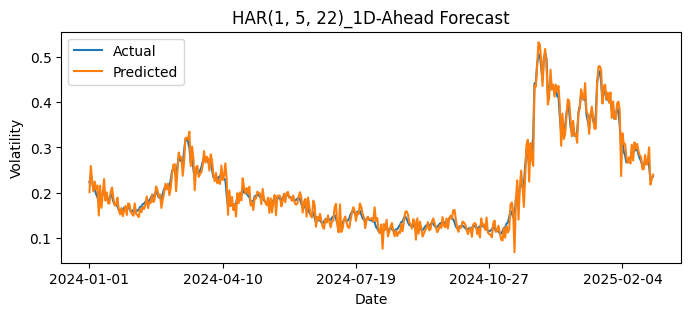

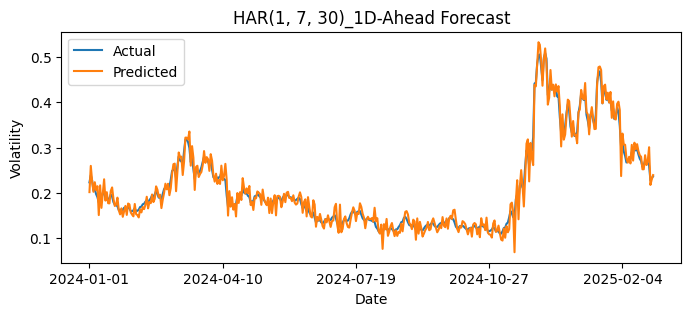

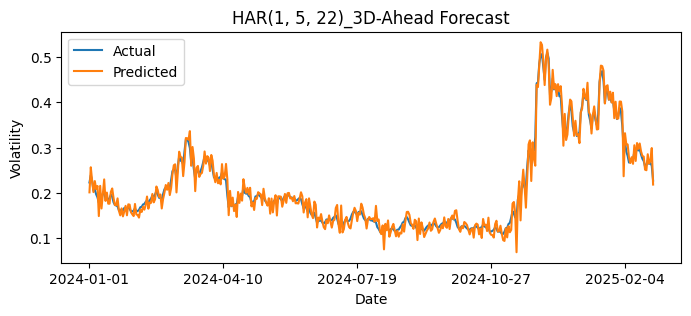

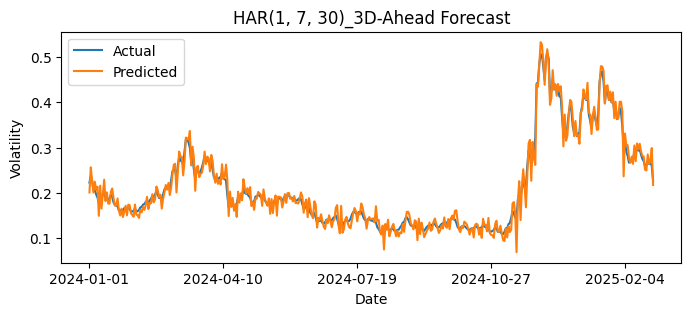

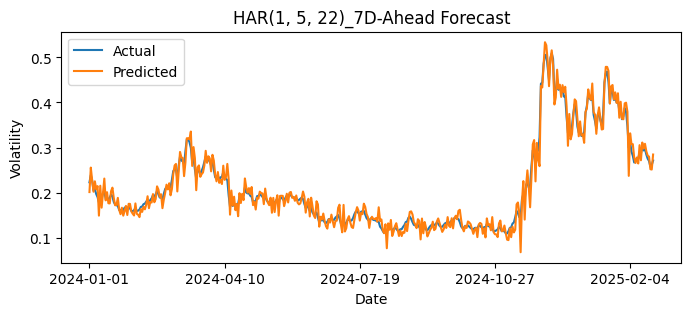

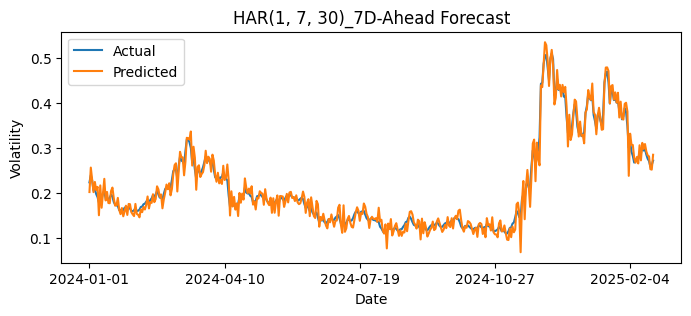

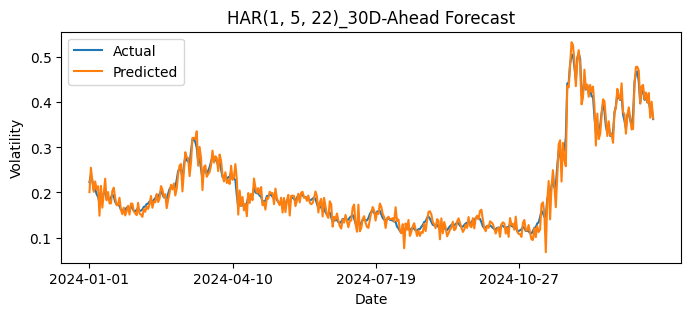

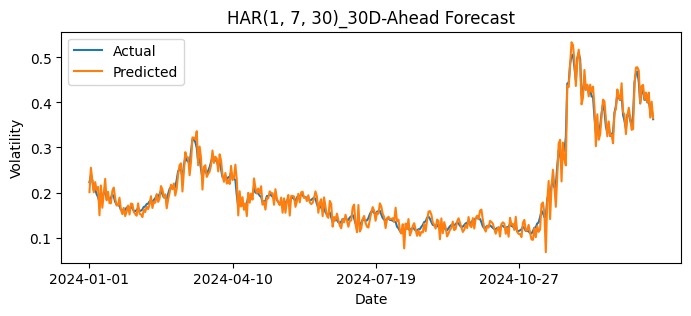

In [17]:
for h in [1, 3, 7, 30]:
    for lags in ((1,5,22), (1,7,30)):
        pred, actual = get_pred(df, lags, h)
        plot_pred(pred, actual, h, lags)